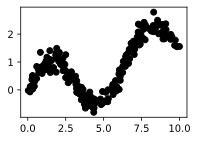

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "svg"


def true_function(X):
    return (np.sin(X) + (X / 7) ** 2)

N = 200
rng = np.random.RandomState(41)
X = rng.rand(N) * 10
y = true_function(X) + rng.randn(N) * 0.2

plt.figure(figsize=(3, 2))
plt.plot(X, y, "ok")

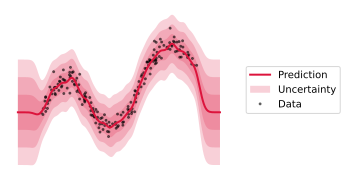

In [2]:
from mini_gpr.models import GPR
from mini_gpr.kernels import RBF
from mini_gpr.viz import show_model_predictions


model = GPR(kernel=RBF(sigma=0.3, scale=0.5), noise=0.3)
model.fit(X, y)
show_model_predictions(model, X, y, marker_size=2)

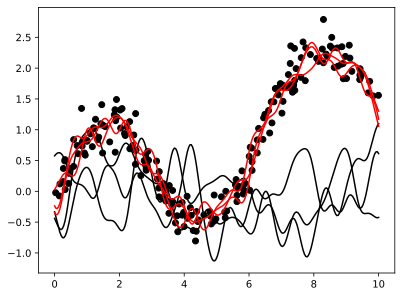

In [3]:
xx = np.linspace(0, 10, 250)
plt.plot(X, y, "ok")
plt.plot(xx, model.sample_prior(xx, 3), c="k")
plt.plot(xx, model.sample_posterior(xx, 3), c="r")

In [4]:
model.log_likelihood

np.float64(-64.1774293820418)

In [5]:
from mini_gpr.opt import optimise_model, maximise_log_likelihood
from mini_gpr.models import GPR
from mini_gpr.kernels import RBF, Constant

best_model = optimise_model(
    GPR(kernel=RBF(), noise=0.3),
    maximise_log_likelihood,
    X,
    y,
    optimise_noise=True
)
best_model

GPR(kernel=RBF(sigma=2.25e+00, scale=1.48e+00), noise=2.00e-01)

In [6]:
best_model.log_likelihood

np.float64(17.351564201631305)

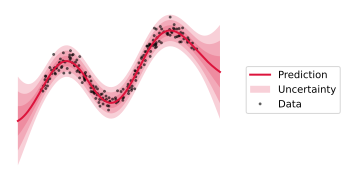

In [7]:
show_model_predictions(
    best_model, X, y, uncertainty_type="predictive", marker_size=2
)

In [8]:
best_model

GPR(kernel=RBF(sigma=2.25e+00, scale=1.48e+00), noise=2.00e-01)

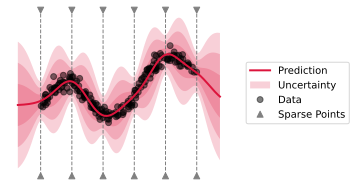

In [9]:
from mini_gpr.models import SoR

M = np.linspace(0, 10, 6)
model = SoR(kernel=RBF(sigma=1.0), noise=3e-1, sparse_points=M)
model.fit(X, y)

show_model_predictions(model, X, y, uncertainty_type="predictive")
# sparse_idxs = np.isin(X, M)
# plt.figure(figsize=(4, 3))
# plt.plot(
#     X[sparse_idxs],
#     y[sparse_idxs],
#     "s",
#     color="black",
#     markersize=10,
#     label="Sparse Points",
# )
# plt.plot(
#     X[~sparse_idxs],
#     y[~sparse_idxs],
#     "o",
#     color="gray",
#     label="Extra Data",
# )

# xx = np.linspace(0, 10, 100)
# yy, sigma_yy = model.predict(xx), model.latent_uncertainty(xx)

# plt.plot(xx, yy, "-", color="crimson", label="Prediction")
# plt.fill_between(
#     xx,
#     yy - sigma_yy,
#     yy + sigma_yy,
#     alpha=0.2,
#     color="crimson",
#     label="Uncertainty",
#     lw=0,
# )

# plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
# plt.axis("off")


In [10]:
best_sparse_model = optimise_model(
    SoR(kernel=RBF(sigma=1.0), noise=3e-1, sparse_points=M),
    maximise_log_likelihood,
    X,
    y,
    optimise_noise=True
)

In [11]:
best_sparse_model

SoR(kernel=RBF(sigma=2.30e+00, scale=1.69e+00), noise=1.99e-01)

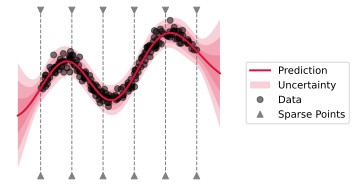

In [12]:
show_model_predictions(best_sparse_model, X, y, uncertainty_type="predictive")

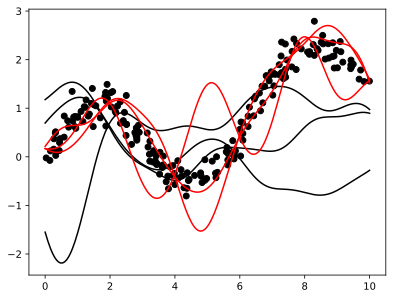

In [13]:
xx = np.linspace(0, 10, 250)
plt.plot(X, y, "ok")
plt.plot(xx, model.sample_prior(xx, 3), c="k")
plt.plot(xx, model.sample_posterior(xx, 3), c="r")


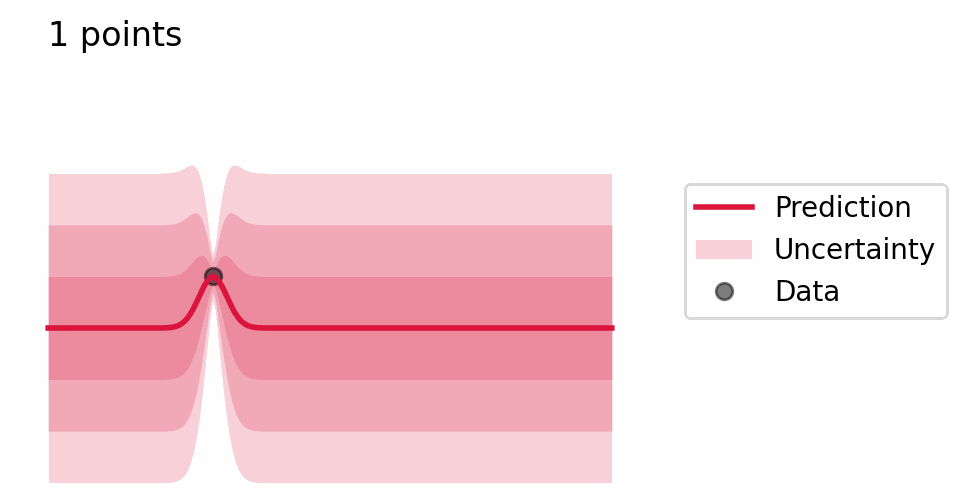

In [30]:
from make_a_gif import gif



def plot(n: int):
    n = max(1, n)
    n = min(n, 25)
    _X, _y = X[:n], y[:n]
    model = optimise_model(
        GPR(RBF(sigma=0.3), noise=0.1),
        maximise_log_likelihood,
        _X,
        _y,
        optimise_noise=True,
        max_iterations=1000,
    )
    show_model_predictions(model, _X, _y, test_points=np.linspace(-1, 11, 200))
    plt.text(-1, 4, f"{n} points", fontsize=12, ha="left", va="top")
    plt.ylim(-2, 4)


gif(
    range(-1, 28),
    plot,
    fps=1.5,
    save_to="1d-gpr.gif",
    savefig_kwargs={"dpi": 200},
)


In [15]:
import numpy as np

def get_grid(xlim, ylim, N=100) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x = np.linspace(xlim[0], xlim[1], N)
    y = np.linspace(ylim[0], ylim[1], N)
    mesh_x, mesh_y = np.meshgrid(x, y)
    return x, y, np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1)

GPR(kernel=RBF(sigma=[-1.51e+04, -4.73e+03], scale=6.21e+03), noise=1.02e+00)


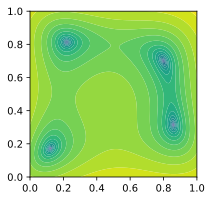

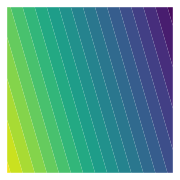

In [16]:
from jaxtyping import Float


def himmelblau(X: Float[np.ndarray, "A 2"]):
    X = X * 10 - 5
    x, y = X.T
    return np.log((x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2)


X_train = np.random.RandomState(42).rand(200, 2)
y_train = himmelblau(X_train)

model = optimise_model(
    GPR(kernel=RBF(sigma=[1, 1]), noise=1e-5),
    maximise_log_likelihood,
    X_train,
    y_train,
    optimise_noise=True
)
print(model)

# test on grid of points
xx, yy, X_test = get_grid((0, 1), (0, 1))
y_true = himmelblau(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(3, 3))
plt.contourf(xx, yy, y_true.reshape(100, 100), cmap="viridis", levels=20)

plt.figure(figsize=(3, 3))
plt.contourf(xx, yy, y_pred.reshape(100, 100), cmap="viridis", levels=20)
# plt.scatter(*X_train.T, c="w", edgecolors="k", clip_on=False)
plt.gca().set_aspect("equal")
plt.axis("off");

In [17]:
np.abs(-1)

np.int64(1)